In [1]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from CAP11NA import CAP11NA
from BM1422 import BM1422
from SM141K import SM141K 
from plotAll import generateActiveList
import random
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt

duration = 100

# `Temperature Sensor Configurations`

(Parameters for TMP117 to be changed by teams)  

### `Continuous conversion (if selected) params`:
Continuous conversion mode: The device continuously performs temperature conversions in this mode, as shown in Table 7-7, and updates the temperature result register at the end of every active conversion. 
* Possible conversion cycle times (see Table 7-7 below): 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
* Possible averaging inputs: 0, 8, 32, 64

### `One-Shot conversion (if selected) params`:
One-shot mode: After the device completes a (temperature conversion) one-shot conversion, the device goes to the low-power shutdown mode. 
* Possible conversion cycle times (first row of Table 7-7): 0.0155, 0.125, 0.5, 1 (conv cycle only consists of active time)
* Possible averaging inputs: 0, 8, 32, 64

<img src='convTimes.png' width="700" height="200">


#### TO-DO (teams set inputs)

In [2]:
time_step = 0.0155
activeTimeParams = [(0, 15, "OS_8_0.0155"), (30, 45, "CC_32_16"), (70, 75, "OS_64_16"), (75,100, "OS_8_0.0155")]

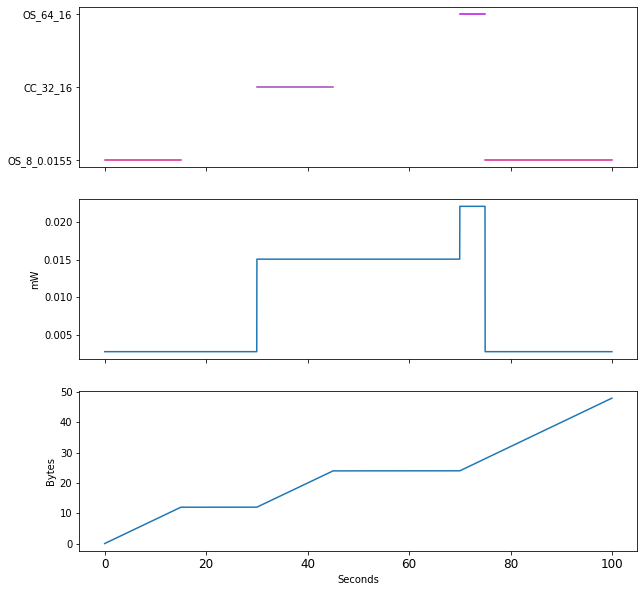

In [3]:
tmp1 = TMP117(time_step, duration, activeTimeParams, loop_rate = 20) # creating TMP117 class
power_tmp, data_tmp, time_tmp = tmp1.Simulation()
tmp1.plotData(power_tmp, data_tmp, time_tmp, activeTimeParams)

In [4]:
modedict = {"OS_16_0.0155": 15, "CC_16_0.0155":30}
activeTimeParams = generateActiveList(duration, modedict=modedict)
tmp2 = TMP117(time_step, duration, activeTimeParams, loop_rate = 20)
tmp2.Simulation();

# `Accelerometer Configurations`

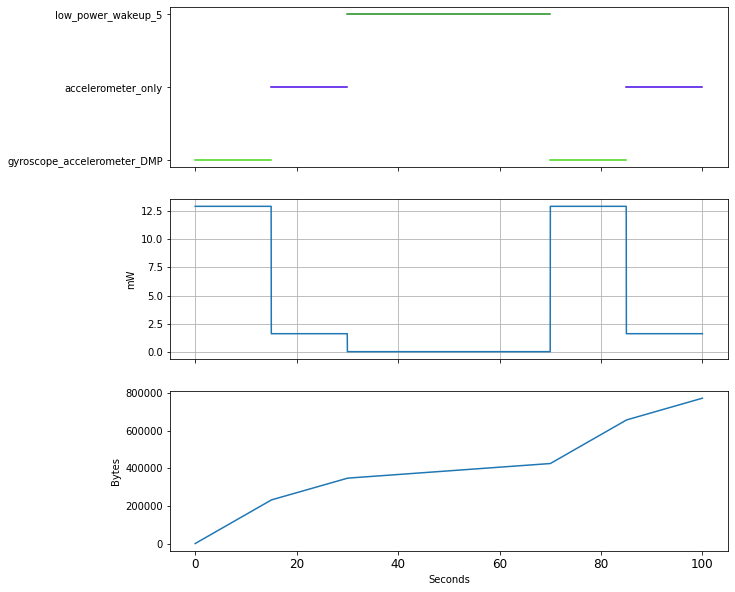

In [5]:
modedict = {"gyroscope_accelerometer_DMP":15, "accelerometer_only":15,"low_power_wakeup_5":40}
active_times = generateActiveList(total_time=100, modedict=modedict)
accel2 = MPU6050(time_step=time_step, duration=duration, loop_rate=20, digital_low_pass=0, sample_rate_divisor=0)

time_acc, power_acc, data_acc = accel2.runSim(active_times)

# `Thermopile Configurations`

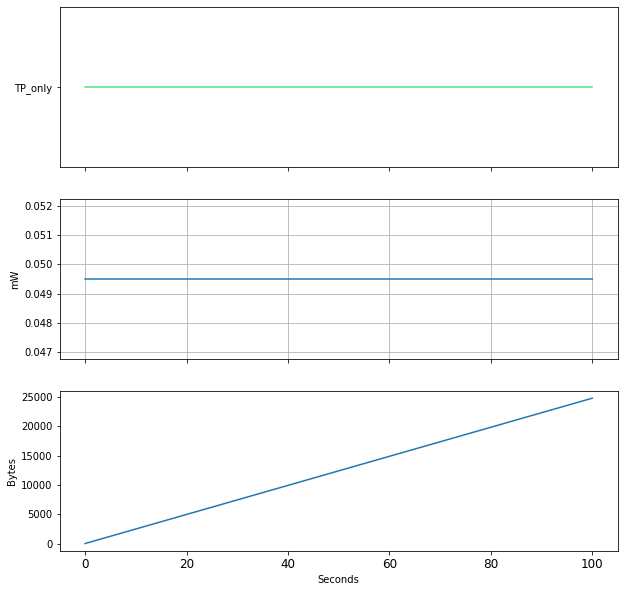

In [6]:
from TP import TP
Thermo = TP(time_step=time_step, duration=duration, loop_rate=20)
active_times = [(0,100,"TP_only")]
tp_time, tp_power, tp_data = Thermo.runSim(active_times)

# `Capacitor Configurations`

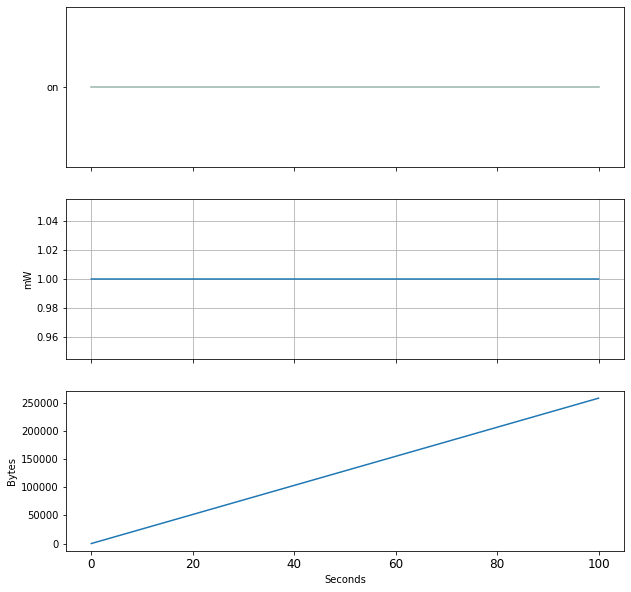

In [7]:
cap = CAP11NA(loop_rate=20, duration=duration, time_step=time_step)
cap_active_times = [(0,100,"on")]
cap_time, cap_power, cap_data = cap.runSim(cap_active_times)

# `Magnetometer Configurations`

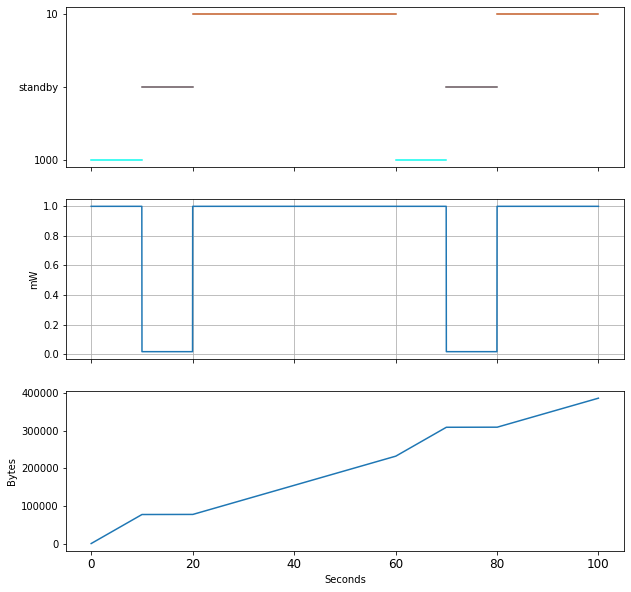

In [8]:
foo = BM1422(loop_rate=20, duration=duration, time_step=time_step)
#for magnetometer, the certain mode is the timing specification, or standby.
modedict = {"1000":10, "standby":10,"10":40}
mag_activetimes = generateActiveList(total_time=duration, modedict=modedict)
mag_time, mag_power, mag_data = foo.runSim(mag_activetimes)

# `Solar Panel Model`

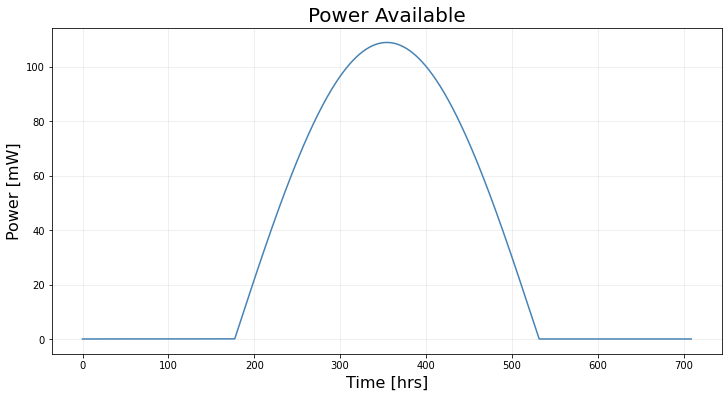

In [9]:
solar_panel_model = SM141K(start_time_hrs=0, duration_hrs=709, time_step_seconds=30, latitude=45)
solar_panel_model.plotPowerAvailable()

# `All Together`

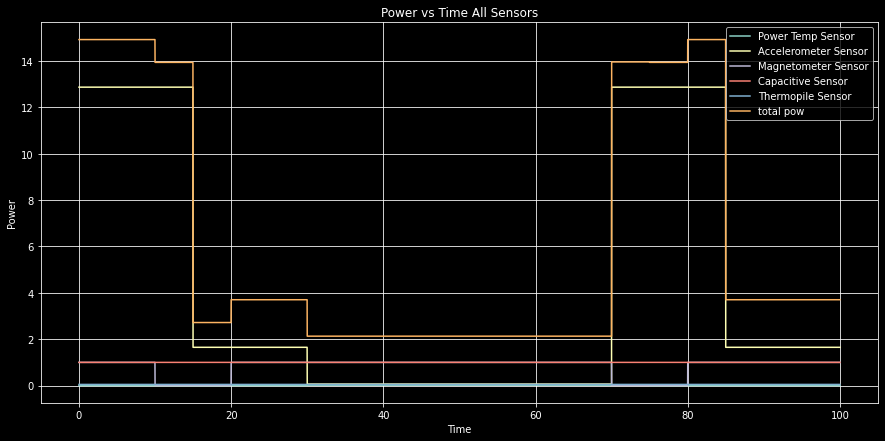

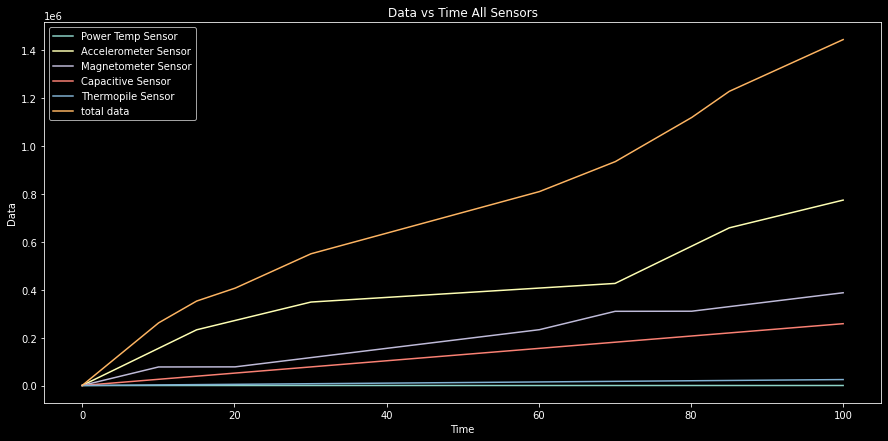

In [10]:
#plotAll()
plt.style.use('dark_background')

plt.figure(figsize=(15, 7))

plt.plot(time_tmp, power_tmp, label = "Power Temp Sensor")
plt.plot(time_acc, power_acc, label = "Accelerometer Sensor")
plt.plot(mag_time, mag_power, label = "Magnetometer Sensor")
plt.plot(cap_time, cap_power, label = "Capacitive Sensor")
plt.plot(tp_time, tp_power, label = "Thermopile Sensor")


total_pow2 = power_tmp + mag_power + power_acc + cap_power + tp_power
plt.plot(mag_time, total_pow2, label = "total pow")

#plt.plot(time_thermo, power_thermo)
plt.grid(visible=True)

plt.xlabel("Time")
plt.ylabel("Power")
plt.title("Power vs Time All Sensors")
plt.legend()

plt.figure(figsize=(15,7))
plt.plot(time_tmp, data_tmp, label = "Power Temp Sensor")
plt.plot(time_acc, data_acc, label = "Accelerometer Sensor")
plt.plot(mag_time, mag_data, label = "Magnetometer Sensor")
plt.plot(cap_time, cap_data, label = "Capacitive Sensor")
plt.plot(tp_time, tp_data, label = "Thermopile Sensor")

total_data = data_tmp + mag_data + data_acc + cap_data + tp_data
plt.plot(mag_time, total_data, label = "total data")

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("Data vs Time All Sensors")
plt.legend();


[192.76666666666665, 516.2333333333333]

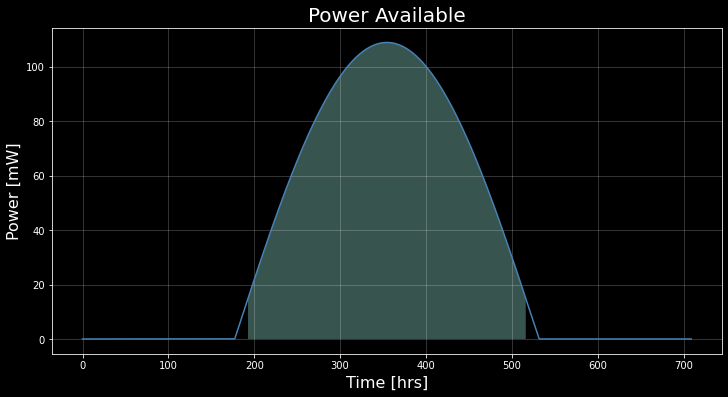

In [14]:
max_power_used = max(total_pow2)
solar_panel_model.plotPowerAndTimesPossible(max_power = max_power_used)